# EDSA - Climate Change Belief Analysis 2021
### Team TS5 Classification

<div align="center" style="width: 1000px; font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/CPNMorgan/Team_TS5_JHB_Classification/main/climat change.jpg"
     alt="Titanic"
     style="float: center; padding-bottom=0.5em"
     width=1000px/>

</div>

# Challange Description

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

# Introduction

# Importing Packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from plotly import graph_objs as go
import seaborn as sns

#nlp
import string
import re    #for regex
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from nltk.tokenize import TweetTokenizer   
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_union

#models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/edsa-climate-change-belief-analysis-2021/sample_submission.csv
/kaggle/input/edsa-climate-change-belief-analysis-2021/train.csv
/kaggle/input/edsa-climate-change-belief-analysis-2021/test.csv


In [2]:
test_df = pd.read_csv('../input/edsa-climate-change-belief-analysis-2021/test.csv')
train_df = pd.read_csv('../input/edsa-climate-change-belief-analysis-2021/train.csv')

## First look into data

In [3]:
train_df.head(10)

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954
5,1,Worth a read whether you do or don't believe i...,425577
6,1,RT @thenation: Mike Pence doesn’t believe in g...,294933
7,1,RT @makeandmendlife: Six big things we can ALL...,992717
8,1,@AceofSpadesHQ My 8yo nephew is inconsolable. ...,664510
9,1,RT @paigetweedy: no offense… but like… how do ...,260471


In [4]:
#check the shape of the data
train_df.shape, test_df.shape

((15819, 3), (10546, 2))

In [5]:
#unique sentiments
train_df['sentiment'].unique()

array([ 1,  2,  0, -1])

In [6]:
#check for nulls
train_df.isnull().sum(), test_df.isnull().sum()

(sentiment    0
 message      0
 tweetid      0
 dtype: int64,
 message    0
 tweetid    0
 dtype: int64)

In [7]:
#describe the data
train_df.describe()

,sentiment,tweetid
count,15819.000000,15819.000000
mean,0.917504,501719.433656
std,0.836537,289045.983132
min,-1.000000,6.000000
25%,1.000000,253207.500000
50%,1.000000,502291.000000
75%,1.000000,753769.000000
max,2.000000,999888.000000


## EDA

- Distribution of sentiments

In [8]:
copy_df = train_df.copy()
# Labeling the target
copy_df['sentiment'] = [['Negative', 'Neutral', 'Positive', 'News'][x+1] for x in copy_df['sentiment']]

In [9]:
dist = copy_df.groupby('sentiment').count()['message'].reset_index().sort_values(by='message',ascending=False)
dist.style.background_gradient(cmap='Greens')

,sentiment,message
3,Positive,8530
2,News,3640
1,Neutral,2353
0,Negative,1296


<AxesSubplot:xlabel='sentiment', ylabel='count'>

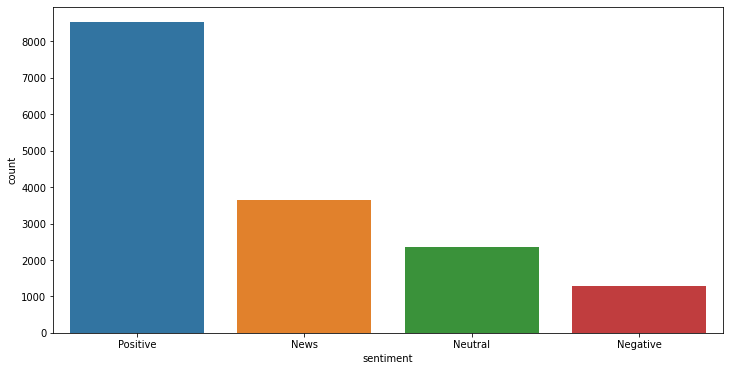

In [10]:
labels = []
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=copy_df)

- Funnel chart to get more insight from sentiments

In [11]:
fig = go.Figure(go.Funnelarea(
    text =dist.sentiment,
    values = dist.message,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

- checking average length of each sentiment catergory

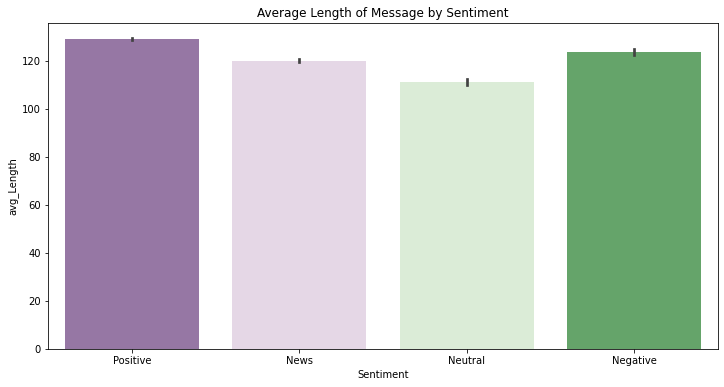

In [12]:
plt.figure(figsize=(12,6))
sns.barplot(x='sentiment', y=copy_df['message'].apply(len) ,data = copy_df, palette='PRGn')
plt.ylabel('avg_Length')
plt.xlabel('Sentiment')
plt.title('Average Length of Message by Sentiment')
plt.show()

## Data cleaning

In [13]:
# function that takes a tweet message and a character e.g @ and remove the character from the sentence
# Returns the sentence without the character
# Define the function to remove the punctuation
def remove_punctuations(msg):
    msg = str(msg).lower()
    msg = re.sub('\[.*?\]', '', msg)
    msg = re.sub('https?://\S+|www\.\S+', '', msg)
    msg = re.sub('<.*?>+', '', msg)
    msg = re.sub('[%s]' % re.escape(string.punctuation), '', msg)
    msg = re.sub('\n', '', msg)
    msg = re.sub('\w*\d\w*', '', msg)
    msg = re.sub('rt','',msg)
    return msg



In [14]:
train_df['clean_message'] = train_df['message'].apply(lambda x:remove_punctuations(x))
train_df.head()

,sentiment,message,tweetid,clean_message
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...
1,1,It's not like we lack evidence of anthropogeni...,126103,its not like we lack evidence of anthropogenic...
2,2,RT @RawStory: Researchers say we have three ye...,698562,rawstory researchers say we have three years ...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired was a pivotal year in the...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,soynoviodetodas its and a racist sexist clim...


### Removing Stop Words

In [15]:
train_df['clean_message'] = train_df['clean_message'].apply(lambda x: ' '.join([a for a in x.split() if len(a)>3]))

In [16]:
train_df.head()

,sentiment,message,tweetid,clean_message
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor chief doesnt think carbon dioxide...
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming
2,2,RT @RawStory: Researchers say we have three ye...,698562,rawstory researchers have three years climate ...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired pivotal year climate change
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,soynoviodetodas racist sexist climate change d...


In [17]:
 train = train_df['clean_message']

vectorizer = CountVectorizer()
count_vectorized = vectorizer.fit_transform(train)

In [18]:
# Converting the collection of clean messages to a matrix of TF-IDF features
data = train_df['clean_message']

vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
vectorized = vectorizer.fit_transform(data)

In [19]:
import scipy.sparse

# Defining the features as well as the label
X = scipy.sparse.hstack([vectorized, count_vectorized])
y = train_df['sentiment']

In [20]:
from sklearn.model_selection import train_test_split

# Splitting the previously defined features and label of your dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
# Creating a list of all the models to train
algs = [LogisticRegression(random_state = 5), SVC(kernel = 'linear', random_state = 5), SVC(kernel = 'rbf', random_state = 5)
        ,MultinomialNB(), KNeighborsClassifier(), DecisionTreeClassifier(max_depth=6),RandomForestClassifier()]

In [22]:
# Fitting models onto the training data and predicting.
for i in range(0, len(algs)):
    text_clf = Pipeline([('clf', algs[i])])
    text_clf.fit(X_train, y_train)  
    predictions = text_clf.predict(X_test)
    
    
    print(algs[i])
    print(metrics.confusion_matrix(y_test,predictions))
    print(metrics.classification_report(y_test,predictions))
    print('F1_score: ',round(metrics.f1_score(y_test,predictions, average = 'weighted'),3))
    print('-------------------------------------------------------')

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(random_state=5)
[[ 178   65  166   19]
 [  27  314  327   69]
 [  31  162 2428  240]
 [   6   33  279  877]]
              precision    recall  f1-score   support

          -1       0.74      0.42      0.53       428
           0       0.55      0.43      0.48       737
           1       0.76      0.85      0.80      2861
           2       0.73      0.73      0.73      1195

    accuracy                           0.73      5221
   macro avg       0.69      0.61      0.64      5221
weighted avg       0.72      0.73      0.72      5221

F1_score:  0.717
-------------------------------------------------------
SVC(kernel='linear', random_state=5)
[[ 200   69  142   17]
 [  54  369  248   66]
 [  90  267 2237  267]
 [  16   72  243  864]]
              precision    recall  f1-score   support

          -1       0.56      0.47      0.51       428
           0       0.47      0.50      0.49       737
           1       0.78      0.78      0.78      2861
           2     

## References
- Websites used for insipiration

- analyticsvidhya: https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/
- towardsdatascience: https://towardsdatascience.com/how-to-efficiently-remove-punctuations-from-a-string-899ad4a059fb
- codegrepper:  https://www.codegrepper.com/code-examples/python/pandas+series+remove+punctuation